# Training a simple neural network model with different optimizers on the Iris dataset
### Reza Akbarian Bafghi

In this notebook, first of all, we show the structure of datasets. Afterward, I did EDA on the Iris dataset introduced in the class. In the next part of this report, I defined a simple neural network, and I trained this network on the aforementioned dataset with different settings. I changed the optimizer, loss function, and learning rate to measure their importance on this dataset.

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm
import seaborn as sns
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import tqdm
import time
from sklearn.preprocessing import StandardScaler

/projects/reak3132/software/anaconda/envs/torch35/lib/python3.5/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load data

In [2]:
iris = load_iris()

##### Print different keys of dictionary of the Iris

In [3]:
print(list(iris.keys()))

['DESCR', 'data', 'filename', 'target_names', 'feature_names', 'target']


In [4]:
x = iris['data']
y = iris['target']
target_names = iris['target_names']
feature_names = iris['feature_names']

##### Size of the dataset

In [5]:
len(x)

150

##### Number of each target

In [6]:
outputs = dict(Counter(y))
for i in outputs:
    print(target_names[i],outputs[i])

setosa 50
versicolor 50
virginica 50


##### Print different features of this dataset

In [7]:
print(feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


#### EDA - The Iris dataset

##### Visualize the data

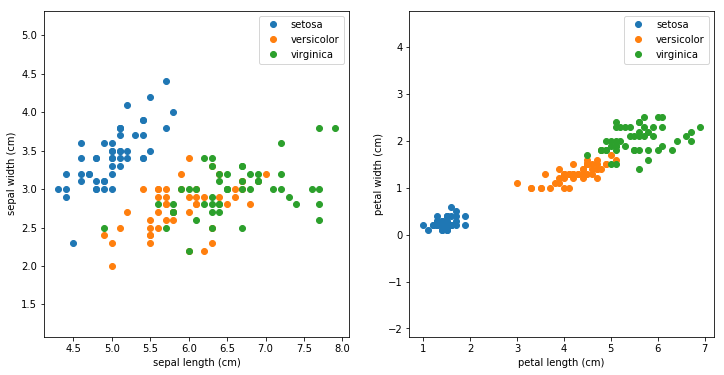

In [8]:
iris = sns.load_dataset("iris")
fig, axes = plt.subplots(1,2, figsize=(12, 6))
for j in range(2):
    for target, target_name in enumerate(target_names):
        X_plot = x[y == target]
        axes[j].plot(X_plot[:, j*2], X_plot[:, j*2+1], 
                 linestyle='none', 
                 marker='o', 
                 label=target_name)
    axes[j].set_xlabel(feature_names[j*2])
    axes[j].set_ylabel(feature_names[j*2+1])
    axes[j].axis('equal')
    axes[j].legend()

Setosa has a smaller sepal length, petal length, and petal width than other species, while it has higher sepal width than others. Virginia has higher pedal width, petal length, and, overall, sepal length than other species. Versicolor has average petal length and petal width, and its sepal has a similar distribution to Virginia.

##### Histogram and boxplot of different features

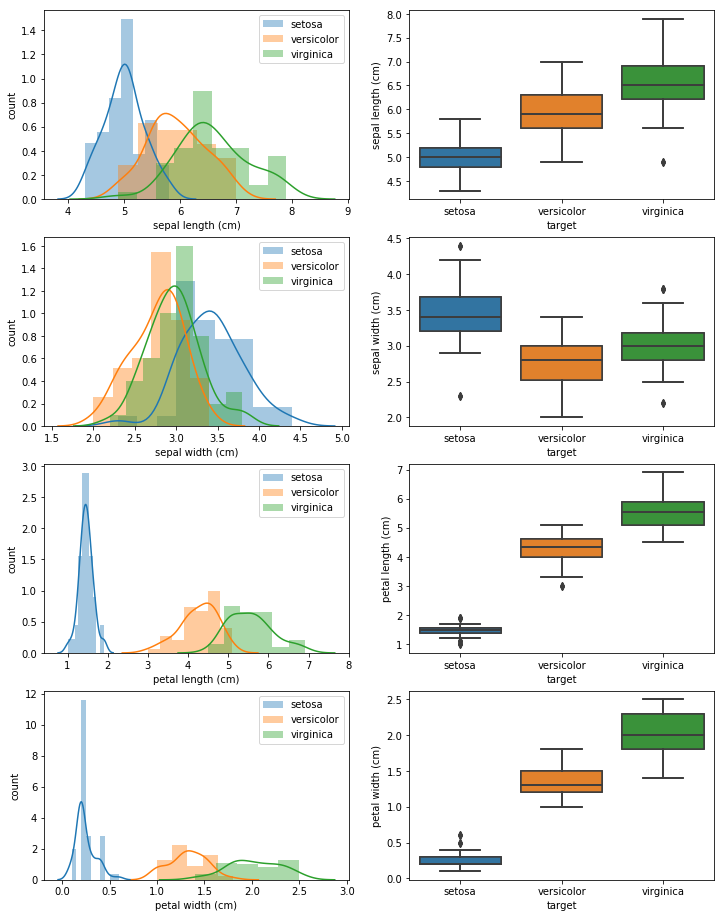

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for k, feature_name in enumerate(feature_names):
    tmp = feature_name.split()
    for target, target_name in enumerate(target_names):
        X_plot = x[y == target]
        sns.distplot(X_plot[:,k],label=target_name, ax=axes[k,0])
        sns.boxplot(x=iris["species"], y=iris[tmp[0]+'_'+tmp[1]], ax=axes[k,1] )
    axes[k,0].set(xlabel=feature_name, ylabel='count')
    axes[k,1].set(xlabel='target', ylabel=feature_name)
    axes[k,0].legend()

In column one, except for sepal width, we can see other features of these species have clear different distributions. In the other column, we can observe there are some outliers in the features of species. For example, there are several outlier values for the sepal width of Setosa, which are higher than the upper bound or lower than the lower bound.

##### Plot a pairwise relationships in this dataset

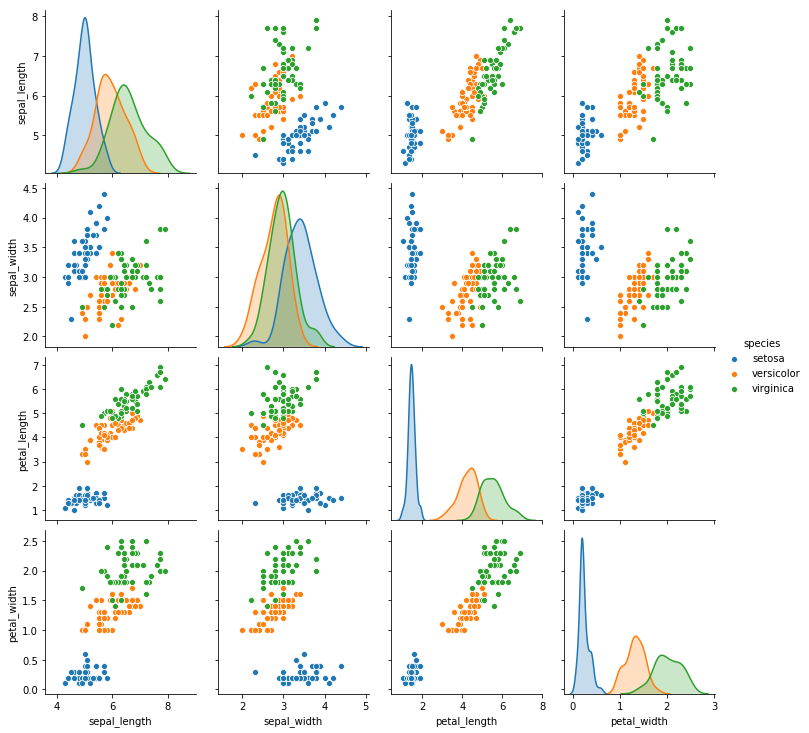

In [10]:
iris = sns.load_dataset("iris")
g = sns.pairplot(iris,hue='species')

In this plot, we can observe that Setosa has a more obvious difference in each feature, which is indicated by the blue color. Features of Versicolor are average in most cases, while features of Virginica, which has a similar distribution to Versicolor, have a higher length and width amount than Versicolor's on average.

##### Correlation between features

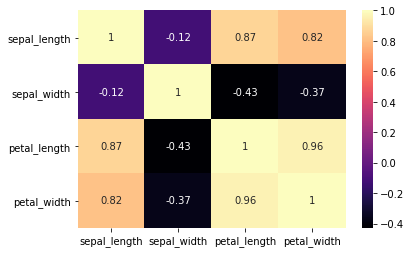

In [11]:
sns.heatmap(iris.corr(),annot=True,cmap='magma');

We can observe these features have a good correlation:

    - Petal length and petal width
    - Petal length and Sepal length
    - Sepal length and petal width
    - Sepal length and petal length
    
while, these features do not have a good correlation:

    - Sepal length and Sepal width
    - Sepal width and petal width
    - Sepal width and petal length

#### Training Models

##### Define a base model constructor

My models will have two layers, and I use ReLU as an activation function and Softmax at last layer.

In [12]:
class NNModel(torch.nn.Module):

    def __init__(self):
        super(NNModel, self).__init__()
        self.linear1 = torch.nn.Linear(4, 50)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(50, 50)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(50, 3)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x

In [13]:
model = NNModel()
model

NNModel(
  (linear1): Linear(in_features=4, out_features=50, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=50, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)

##### Normalize Data

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

##### Split the dataset into training and testing
    - 80% of the training dataset will be our training dataset.
    - 20% of the training dataset will be our validation dataset.
We will not have test dataset because our dataset is very small.

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

We define functions to define optimizer and loss functions based on the query

In [16]:
def create_optimizer(model,name_optim, lr):
    if name_optim == 'Adam':
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif name_optim == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=lr)
    elif name_optim == 'Adagrad':
        return torch.optim.Adagrad(model.parameters(), lr=lr)
    elif name_optim == 'Adadelta':
        return torch.optim.Adadelta(model.parameters(), lr=lr)
    
def create_loss_function(name_loss):
    if name_loss == 'MSELoss':
        return nn.MSELoss()
    elif name_loss == 'L1Loss':
        return nn.L1Loss()
    elif name_loss == 'CrossEntropyLoss':
        return nn.CrossEntropyLoss()

In this function, we train the model based on the query.

In [17]:
def train_model(X_train, X_val, y_train, y_val,EPOCHS,name_optim,name_loss,lr):
    start_time = time.time()
    
    model = NNModel()

    loss_list = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    optimizer = create_optimizer(model,name_optim,lr)

    loss_fn = create_loss_function(name_loss)
    if name_loss != 'CrossEntropyLoss':
        y_train = F.one_hot(y_train.to(torch.int64), num_classes=3)
        y_train = y_train.to(torch.float32)
    for epoch in tqdm.trange(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()

        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred = model(X_val)
            correct = (torch.argmax(y_pred, dim=1) == y_val).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
    time_spend = time.time() - start_time
    return loss_list, accuracy_list,time_spend

##### Train models with different loss functions, but optimzer and learning rate are fixed.

In [86]:
loss_functions = ['MSELoss','CrossEntropyLoss','L1Loss']
optimizer = 'Adam'
learning_rate = 0.01
loss_list = {}
time_spend = {}
accuracy_list = {}
for loss_function in loss_functions:
    loss_list[loss_function], accuracy_list[loss_function],time_spend[loss_function] = train_model(X_train, X_val, y_train, y_val, 300,optimizer,loss_function,learning_rate)

100%|██████████| 300/300 [00:00<00:00, 734.55it/s]


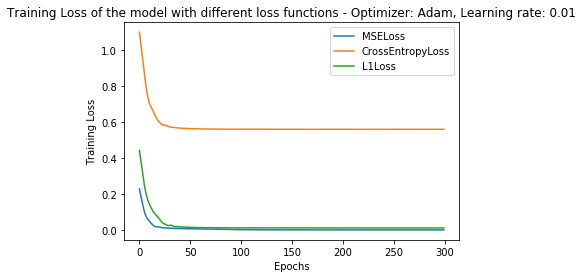

In [87]:
for i, loss_function in enumerate(loss_functions):
    plt.plot(loss_list[loss_function],
            label=loss_function)
plt.title('Training Loss of the model with different loss functions - Optimizer: '+optimizer+', Learning rate: '+str(learning_rate))
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend();

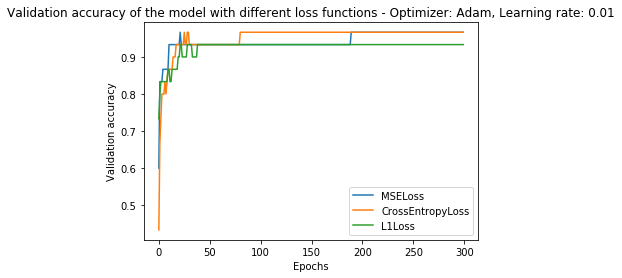

In [88]:
for i, loss_function in enumerate(loss_functions):
    plt.plot(accuracy_list[loss_function],
            label=loss_function)
plt.title('Validation accuracy of the model with different loss functions - Optimizer: '+optimizer+', Learning rate: '+str(learning_rate))
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend();

In [89]:
time_spend

{'CrossEntropyLoss': 0.41460299491882324,
 'L1Loss': 0.4104337692260742,
 'MSELoss': 0.39948225021362305}

We can see all loss functions were well. Maybe because our dataset is very simple, we could not see big differences in the plot. I changed the encoding of training datasets for L1 and MSE loss functions. As a matter of fact, I changed them from Integer encoding to one-hot encoding. For example, targets from (setosa, 0), (versicolor, 1), and (virginica, 2) were changed to (setosa, [1,0,0]), (versicolor, [0,1,0]), and (virginica, [0,0,1]). The training time was almost the same for each item.

##### Train models with different optimzers and learning rates, but loss functions is fixed.

In [18]:
optimizers = ['SGD','Adam','Adagrad','Adadelta']
learning_rates = [0.1,0.01,0.001]
loss_function = 'CrossEntropyLoss'
loss_list = {}
time_spend = {}
accuracy_list = {}
for optimizer in optimizers:
    for learning_rate in learning_rates:
        loss_list[(optimizer,learning_rate)], accuracy_list[(optimizer,learning_rate)],time_spend[(optimizer,learning_rate)] = train_model(X_train, X_val, y_train, y_val, 300,optimizer,loss_function,learning_rate)

100%|██████████| 300/300 [00:00<00:00, 728.07it/s]


##### Plotting each optimizer with different learning rate.

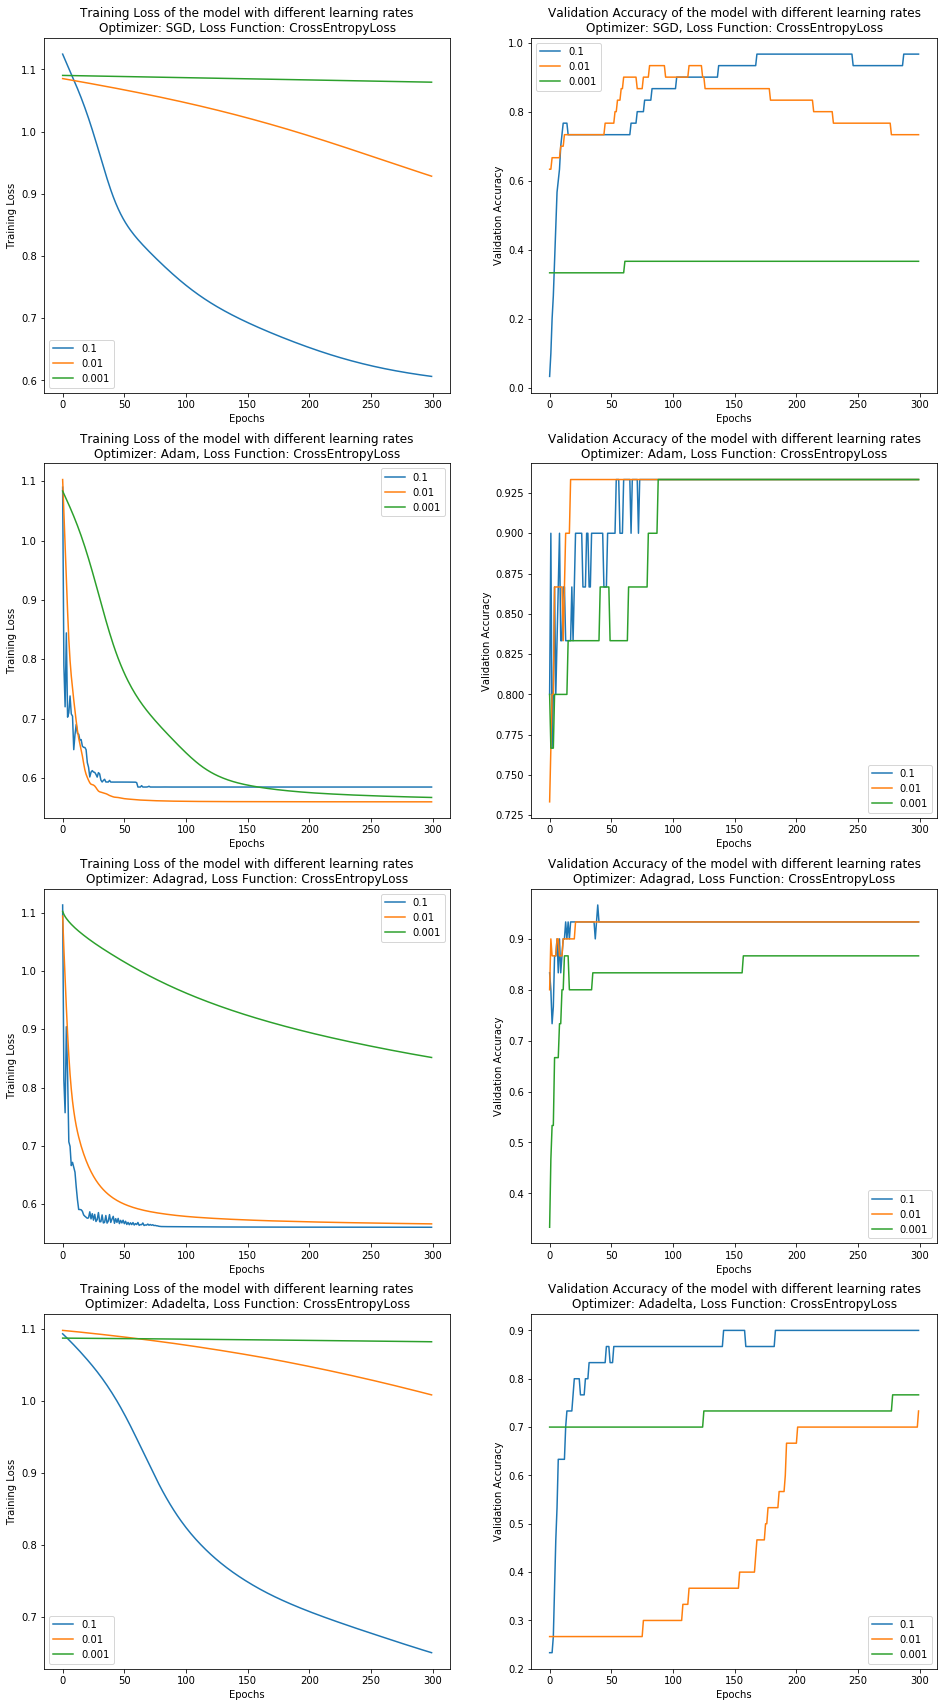

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(16,30))
for i, optimizer in enumerate(optimizers):
    for j, learning_rate in enumerate(learning_rates):
        axes[i,0].plot(loss_list[(optimizer,learning_rate)],label=learning_rate)
    for j, learning_rate in enumerate(learning_rates):
        axes[i,1].plot(accuracy_list[(optimizer,learning_rate)],label=learning_rate)
    axes[i,0].set(xlabel='Epochs', ylabel='Training Loss', title='Training Loss of the model with different learning rates\nOptimizer: '+optimizer+', Loss Function: '+loss_function)
    axes[i,1].set(xlabel='Epochs', ylabel='Validation Accuracy', title='Validation Accuracy of the model with different learning rates\nOptimizer: '+optimizer+', Loss Function: '+loss_function)
    axes[i,0].legend()
    axes[i,1].legend();

We explore the performance of each optimizer here:

**SGD:** The model could not converge with a low learning rate when we used SGD as an optimizer. We can see model had the best performance when it used 0.1 as a learning rate.

**Adam:** The model converges with all learning rates, but it seems that when the learning rate is 0.01, the model finds lower training loss.

**Adagrad:** The model can not converge well when the learning rate was 0.001. Therefore, we can assume that Adagrad cannot train this dataset when we use low learning rate.

**Adadelta:** The model converge only when the learning rate was 0.1. However, other optimzers had better performance than this optimzer overally.

##### Plotting training loss for all optimizers with different learning rate in one plot!

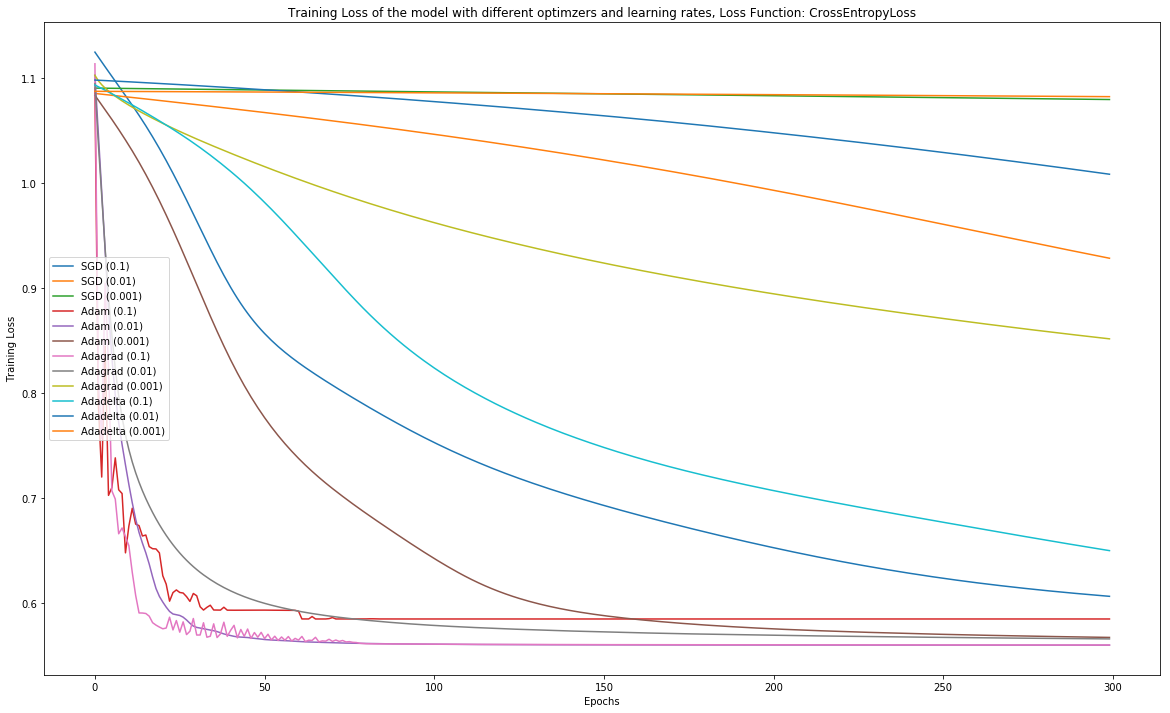

In [27]:
plt.figure(figsize=(20, 12))
for i, optimizer in enumerate(optimizers):
    for j, learning_rate in enumerate(learning_rates):
        string_label = optimizer+' ('+str(learning_rate)+')'
        plt.plot(loss_list[(optimizer,learning_rate)],label=string_label)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss of the model with different optimzers and learning rates, '+ 'Loss Function: '+loss_function)
plt.legend();

We can find out that mainly Adam and Adagrad could make lower losses in this dataset than other optimizers.

##### Plotting validation accuracy for all optimizers with different learning rate in one plot!

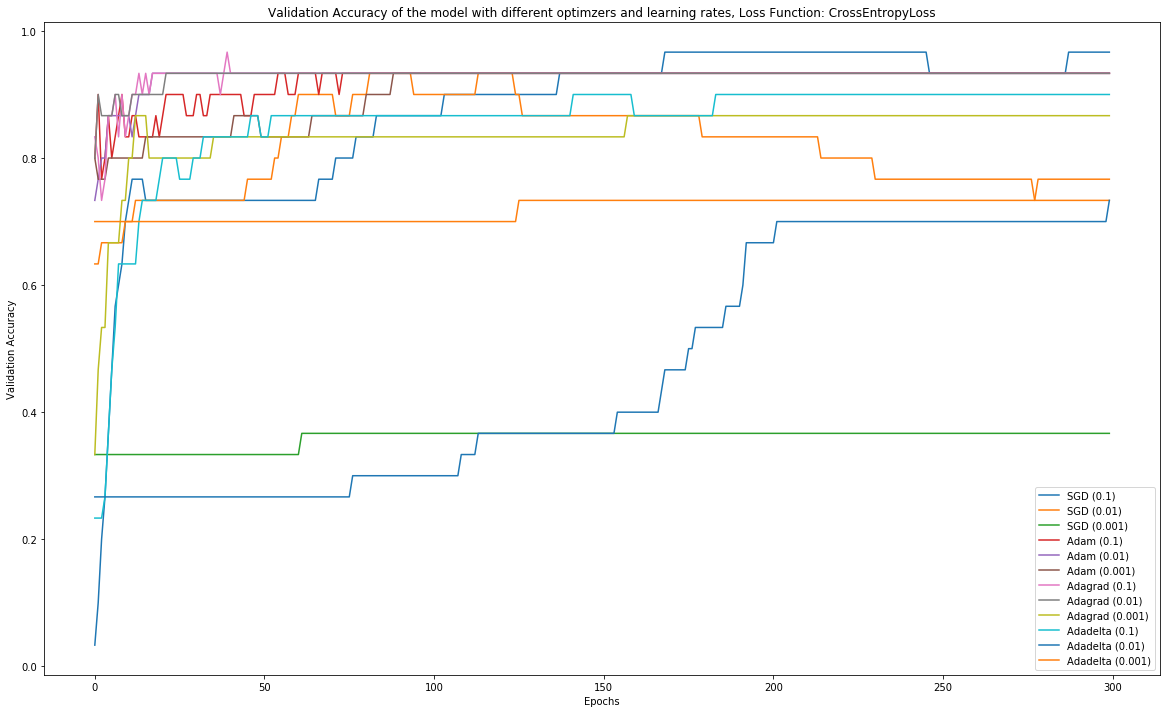

In [28]:
plt.figure(figsize=(20, 12))
for i, optimizer in enumerate(optimizers):
    for j, learning_rate in enumerate(learning_rates):
        string_label = optimizer+' ('+str(learning_rate)+')'
        plt.plot(accuracy_list[(optimizer,learning_rate)],label=string_label)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy of the model with different optimzers and learning rates, '+ 'Loss Function: '+loss_function)
plt.legend();

The best accuracy was for SGD (0.1), and the worst one was for SGD (0.001) among these optimizers and learning rates, which can show us how much the learning rate is important! Adam (0.1), Adagrad (0.1), and Adagrad (0.01) were the second best optimizers.

In [105]:
time_spend

{('Adadelta', 0.001): 0.4972245693206787,
 ('Adadelta', 0.01): 0.5082621574401855,
 ('Adadelta', 0.1): 0.514686107635498,
 ('Adagrad', 0.001): 0.5003612041473389,
 ('Adagrad', 0.01): 0.46956849098205566,
 ('Adagrad', 0.1): 0.48244237899780273,
 ('Adam', 0.001): 0.42743802070617676,
 ('Adam', 0.01): 0.4035830497741699,
 ('Adam', 0.1): 0.41997790336608887,
 ('SGD', 0.001): 0.30036115646362305,
 ('SGD', 0.01): 0.4260990619659424,
 ('SGD', 0.1): 0.3206746578216553}

It seems that, among these 4 optimizers, SGD was the fastest, and Adadelta was the slowest optimizer.

#### Conclusions
We explore the Iris dataset and summarize some points here:

    - Except for sepal width, we can see other features of these species have clear different distributions.
    - There are some outliers in the features of species.
    - Setosa has a more obvious difference in each feature. Features of Versicolor are average in most cases, while features of Virginica, which has a similar distribution to Versicolor, have a higher length and width amount than Versicolor's on average.
    - Some features have a good correlation (for example, petal length and petal width).

Also, we trained a simple neural network model with different setting on the Iris dataset. This dataset is small, and our conclusions may not be correct in other dataset. Even if we train these models again, the results can be different from presented results. I have not changed the number of epochs, But, in general, some results can make sense. Here, I enamurate some of them:
    
    - Training with all loss functions give us good and similar results, but when we trained model with different optimizers and learning rates, results were different.
    - Except for Adam optimizer, when the learning rate was low, the model could not converge and did not produce a good accuracy on validation dataset.
    - In general Adam and Adagrad could make lower losses in this dataset than other optimizers. Also, the best accuracy was for SGD (0.1), and the worst one was for SGD (0.001), which can show us the importance of learning rate.
    - Among these 4 optimizers, SGD was the fastest, and Adadelta was the slowest optimizer, but when we change loss function we did not see any significant difference in results.

#### Resourses

    - https://janakiev.com/blog/pytorch-iris/
    - https://www.kaggle.com/code/himanshuyadav95627/eda-with-svc-modeling